# 기본 세팅

<Figure size 1500x1200 with 0 Axes>

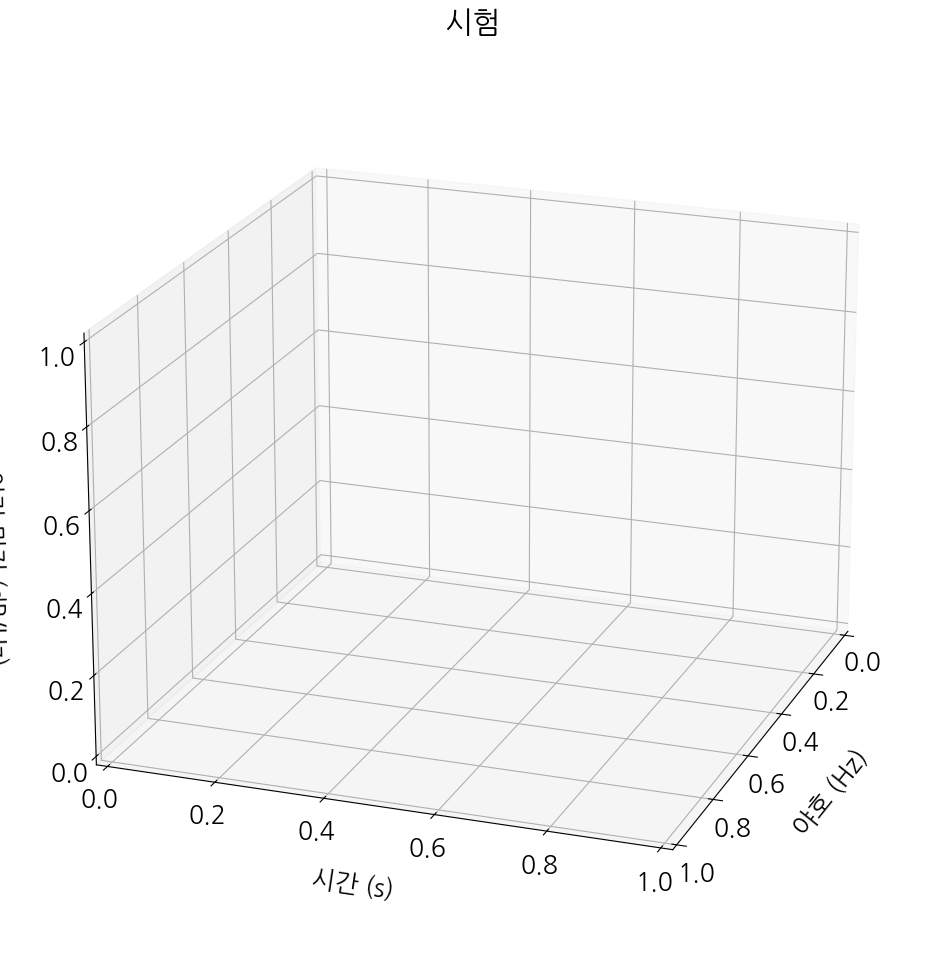

In [1]:
# 필요 라이브러리 불러오기
import matplotlib.font_manager as fm
import os
import matplotlib.pyplot as plt

# apt-get : 패키지 설치 명령어
# -qq : 에러외의 메세지 숨기는 옵션키
# !apt-get -qq install fonts-nanum


fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정
plt.rcParams.update({'axes.unicode_minus': False}) # 마이너스 폰트 깨짐 방지

# 테스트 해보기
fig = plt.figure(figsize=(15, 12))
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(15, 12))

graph_title = '시험'
ax.set_title(f'{graph_title}')
ax.set_xlabel('야호 (Hz)', labelpad=20)
ax.set_ylabel('시간 (s)', labelpad=20)
ax.set_zlabel('이건 뭐지 (dB/Hz)', labelpad=20)

ax.view_init(20, 20)
plt.show()

# EDA

먼저, 사용할 라이브러리 받아왔다.

In [2]:
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

기상청 데이터는 여기서 받았다 : https://data.kma.go.kr/ 

한 번에 12개월씩 받을 수 있어 우선 3년치 데이터만 받아왔다.

In [3]:
# 3개년 데이터 수집
def get_df(years=[2022, 2023, 2024]):
    # 데이터 취합
    df = []
    for year in years:
      try:
        df.append(pd.read_csv(f"rain_{year}.csv", encoding="EUC-KR"))
      except:
        print(f"데이터 파일 rain_{year}.csv를 찾을 수 없습니다. 해당 연도의 데이터가 없거나 파일명이 잘못되었습니다.")
    df = pd.concat(df, axis=0)

    # 쓸데없이 영어가 쓰고 싶은데 기존 데이터 구조도 한 번에 보고 싶어서 새 칼럼 추가함.
    df['location'] = df['지점명']
    df['rain'] = df['강수량(mm)']

    # 일시 데이터 전처리
    df['datetime'] = pd.to_datetime(df['일시'])
    df['date'] = df['datetime'].dt.date
    
    return df 

In [4]:
df = get_df(years=[2022, 2023, 2024])
df.head()

,지점,지점명,일시,강수량(mm),강수량 QC플래그,location,rain,datetime,date
0,90,속초,2022-01-16 04:00,NaN,9.0,속초,NaN,2022-01-16 04:00:00,2022-01-16
1,90,속초,2022-01-16 05:00,NaN,9.0,속초,NaN,2022-01-16 05:00:00,2022-01-16
2,90,속초,2022-01-16 06:00,0.0,NaN,속초,0.0,2022-01-16 06:00:00,2022-01-16
3,90,속초,2022-01-16 07:00,NaN,9.0,속초,NaN,2022-01-16 07:00:00,2022-01-16
4,90,속초,2022-01-16 08:00,NaN,9.0,속초,NaN,2022-01-16 08:00:00,2022-01-16


- 지점 : 관측지점의 지점 번호
- 지점명 : 관측 지점의 소재지
- 일시 : 관측 일시 (시간 간격 1시간)
- 강수량(mm) : 1시간 관측한 강수량 
- 강수량 QC플래그 : 강수량 측정 품질 평가 점수?


지점별로 모든 날짜의 데이터가 있는 것 같지는 않다. 그래서 확인해 보기로 했다.

<Axes: xlabel='location', ylabel='date'>

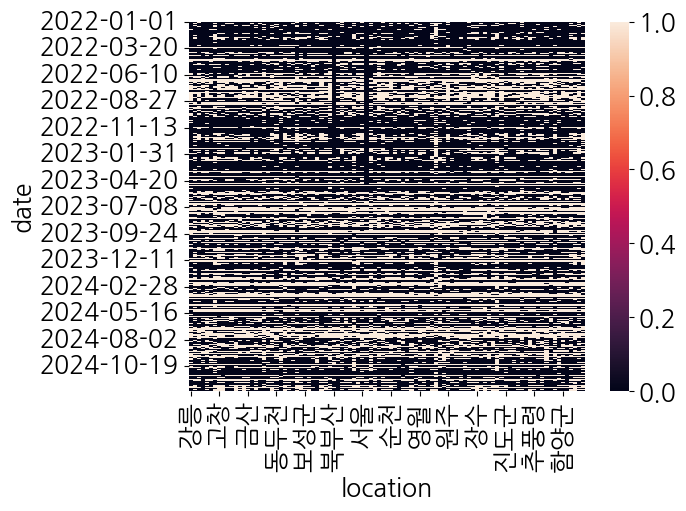

In [5]:
# 지점명 및 일자 별 강수량 카운트 계산
df_lo_dt_count = df.groupby(['location', 'date'])['rain'].count().reset_index()
df_lo_dt_count.columns = ['location', 'date', 'count']
df_hm = df_lo_dt_count.pivot(index='date', columns='location', values='count').fillna(0).astype(int)
sns.heatmap(df_hm, vmin=0, vmax=1)

지점별로 모든 날짜의 데이터가 있는게 나중에 분석에 용이할 것 같다. 나중에 모든 날짜에 관측이 안 된 값은 0으로 채우기로 했다.

자, 이제 데이터를 잘 받아 온 것인지 검토하기 위해, 기상청에 나와 있는 지역별 일별 누적 강수량과 데이터를 비교해 보기로 했다.

그러기 위해, 우선은 일별 누적 강수량을 계산해 보았다.

In [6]:
def get_df_lo_dt(df):
    df_lo_dt = df.groupby(['location', 'date'])['rain'].sum().reset_index()
    df_lo_dt.columns = ['location', 'date', 'total_rain']
    df_lo_dt = df_lo_dt.pivot(index='date', columns='location', values='total_rain').fillna(0).astype(int)
    df_lo_dt.index = pd.to_datetime(df_lo_dt.index)

    return df_lo_dt

df_lo_dt = get_df_lo_dt(df)

가장 익숙한 서울, 비가 많이 오는 7월 데이터를 비교해 보았다.

In [7]:
pd.read_csv('rain_seoul_july_2024.csv', encoding='EUC-KR', skiprows=7).head()

,날짜,지점,강수량(mm)
0,2024-07-01,108,NaN
1,2024-07-02,108,65.1
2,2024-07-03,108,0.8
3,2024-07-04,108,3.6
4,2024-07-05,108,4.1


In [8]:
mask = (df_lo_dt.index >= '2024-07-01') 
mask &= (df_lo_dt.index <= '2024-07-31')
df_lo_df_seoul_july = df_lo_dt[mask]['서울']

display(pd.DataFrame(df_lo_df_seoul_july).head())

# plt.figure(figsize=(15, 6))
# sns.barplot(
#     x=df_lo_df_seoul_july.index,
#     y=df_lo_df_seoul_july.values,
#     color='blue'
# )
# plt.xticks(rotation=45)
# plt.xlabel('date')
# plt.ylabel('total rain (mm)')
# plt.tight_layout()
# plt.show()

,서울
date,
2024-07-01,0
2024-07-02,63
2024-07-03,2
2024-07-04,3
2024-07-05,4


기상청 일별 누적 강수량(https://data.kma.go.kr/stcs/grnd/grndRnList.do)을 보니 수치가 다르다.

7월 2일 누적 강수량은 65.1이라 나와 있는데, 여기는 63.5다. 다른 수치들도 미묘하게 다르다.

기상청에서는 익일 새벽 1시까지의 강수량을 합산해서 그런 것 같다.

한 번 다음날 새벽 1시까지를 하루로 보고 강수량 합산을 해보았다.

In [9]:
def get_df_lo_dt_shifted(df):
    df['shifted_datetime'] = df['datetime'] - pd.Timedelta(hours=1)
    df['shifted_date'] = df['shifted_datetime'].dt.date
    df_lo_dt_shifted = df.groupby(['location', 'shifted_date'])['rain'].sum().reset_index()
    df_lo_dt_shifted.columns = ['location', 'shifted_date', 'total_rain']
    df_lo_dt_shifted = df_lo_dt_shifted.pivot(index='shifted_date', columns='location', values='total_rain').fillna(0).astype(float)
    df_lo_dt_shifted.index = pd.to_datetime(df_lo_dt_shifted.index)

    return df_lo_dt_shifted

df_lo_dt_shifted = get_df_lo_dt_shifted(df)

mask = (df_lo_dt_shifted.index>= '2024-07-01') 
mask &= (df_lo_dt_shifted.index <= '2024-07-31')
df_lo_df_shifted_seoul_july = df_lo_dt_shifted[mask]['서울']


display(pd.DataFrame(df_lo_df_shifted_seoul_july).head())


# plt.figure(figsize=(15, 6))
# sns.barplot(
#     x=df_lo_df_shifted_seoul_july.index,
#     y=df_lo_df_shifted_seoul_july.values,
#     color='blue'
# )
# plt.xticks(rotation=45)
# plt.xlabel('date')
# plt.ylabel('total rain (mm)')
# plt.tight_layout()
# plt.show()

,서울
shifted_date,
2024-07-01,0.0
2024-07-02,65.1
2024-07-03,0.8
2024-07-04,3.6
2024-07-05,4.1


누적 강수량이 이제 잘 들어맞는다.

그럼 이제 실제 결혼식 첫 타임인 11시부터 마지막 타임인 18시 사이의 유효한 누적 강수량을 계산해 보자.

이때, 11시의 누적 강수량은 12시에, 18시의 누적 강수량은 19시에 측정되므로, 12시부터 19시 사이의 누적 강수량 계산이 필요하다.

In [10]:
def get_df_lo_dt_eff(df, start_hour=11, end_hour=19):
    df_eff = df[(df['datetime'].dt.hour >= start_hour) & (df['datetime'].dt.hour <= end_hour)]
    df_lo_dt_eff = df_eff.groupby(['location', 'date'])['rain'].sum().reset_index()
    df_lo_dt_eff.columns = ['location', 'date', 'total_rain']
    df_lo_dt_eff = df_lo_dt_eff.pivot(index='date', columns='location', values='total_rain').fillna(0).astype(float)
    df_lo_dt_eff.index = pd.to_datetime(df_lo_dt_eff.index)

    return df_lo_dt_eff

df_lo_dt_eff = get_df_lo_dt_eff(df)

mask = (df_lo_dt_eff.index>= '2024-07-01') 
mask &= (df_lo_dt_eff.index <= '2024-07-31')
df_lo_df_eff_seoul_july = df_lo_dt_eff[mask]['서울']


display(pd.DataFrame(df_lo_df_eff_seoul_july).head())



# plt.figure(figsize=(15, 6))
# sns.barplot(
#     x=df_lo_df_eff_seoul_july.index,
#     y=df_lo_df_eff_seoul_july.values,
#     color='blue'
# )
# plt.xticks(rotation=45)
# plt.xlabel('date')
# plt.ylabel('total rain (mm)')
# plt.tight_layout()
# plt.show()

,서울
date,
2024-07-01,0.0
2024-07-02,59.4
2024-07-03,0.0
2024-07-04,0.0
2024-07-05,0.0


시각화를 위해 특정 월일의 누적 강수량 평균을 계산했다.

In [11]:
def get_df_mon_day_eff(df_lo_dt_eff, location='서울', year_start=2022, year_end=2024):
    df_ = df_lo_dt_eff.reset_index()
    df_['date'] = pd.to_datetime(df_['date'])
    df_['years'] = df_['date'].dt.year
    df_['months'] = df_['date'].dt.month
    df_['days'] = df_['date'].dt.day
    df_['hours'] = df_['date'].dt.hour

    mask = (df_['years'] >= year_start) & (df_['years'] <= year_end)
    df_ = df_[mask]
    df_lo_dt_eff_seoul = df_[[location, 'months', 'days']].copy()
    df_mon_day_eff = df_lo_dt_eff_seoul.groupby(['months', 'days'])[location].mean().reset_index()
    df_mon_day_eff.columns = ['months', 'days', 'avg_rain']
    df_mon_day_eff = df_mon_day_eff.pivot(index='months', columns='days', values='avg_rain')
    return df_mon_day_eff

# Visualization

In [12]:
def get_df_mon_day_year_eff(df_lo_dt_eff, location='서울', year_start=2022, year_end=2024, months=1, days=1):
    df_ = df_lo_dt_eff.reset_index()
    df_['date'] = pd.to_datetime(df_['date'])
    df_['years'] = df_['date'].dt.year
    df_['months'] = df_['date'].dt.month
    df_['days'] = df_['date'].dt.day
    df_['hours'] = df_['date'].dt.hour

    mask = (df_['months'] == months) & (df_['days'] == days)
    df_ = df_[mask]
    df_lo_dt_eff_seoul = df_[[location, 'years']].copy()
    df_mon_day_year_eff = df_lo_dt_eff_seoul.groupby(['years'])[location].mean().reset_index()
    df_mon_day_year_eff.columns = ['years', 'avg_rain']
    return df_mon_day_year_eff


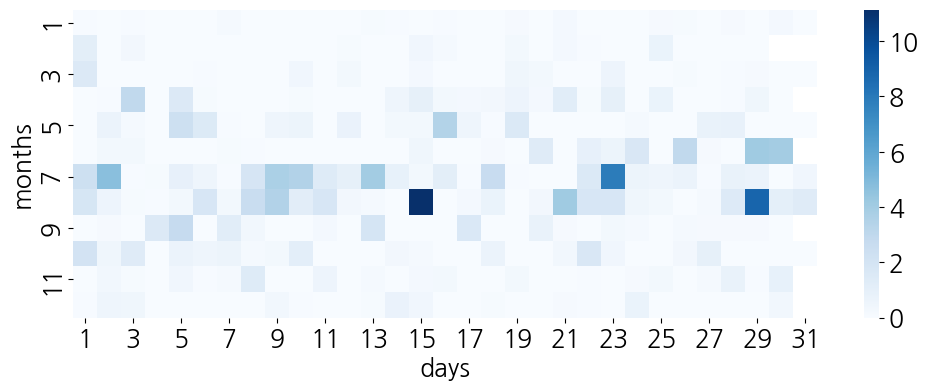

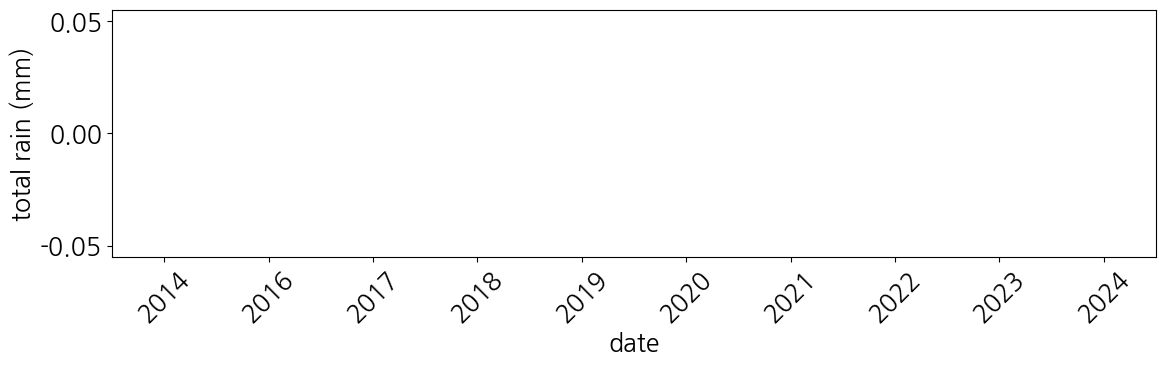

In [13]:
year_start = 2012 # 1994
year_end = 2024
start_hour = 11
end_hour = 13
location = '서울'
selected_month = 5
selected_day = 26

collected_years = list(i for i in range(year_start, year_end+1))
df = get_df(years=collected_years)
df_lo_dt_eff = get_df_lo_dt_eff(df, start_hour=start_hour, end_hour=end_hour)
df_mon_day_eff = get_df_mon_day_eff(df_lo_dt_eff, location=location, year_start=year_start, year_end=year_end)
df_mon_day_year_eff = get_df_mon_day_year_eff(df_lo_dt_eff, location='서울', year_start=year_start, year_end=year_end, months=selected_month, days=selected_day)


plt.figure(figsize=(12, 4))
sns.heatmap(df_mon_day_eff, cmap='Blues')
plt.show()
plt.figure(figsize=(12, 4))
sns.barplot(x=df_mon_day_year_eff['years'], y=df_mon_day_year_eff['avg_rain'], color='blue')
plt.xticks(rotation=45)
plt.xlabel('date')
plt.ylabel('total rain (mm)')
plt.tight_layout()
plt.show()

In [14]:
df_lo_dt_eff.columns

Index(['강릉', '강진군', '강화', '거제', '거창', '경주시', '고산', '고창', '고창군', '고흥', '광양시',
       '광주', '구미', '군산', '금산', '김해시', '남원', '남해', '대관령', '대구', '대구(기)', '대전',
       '동두천', '동해', '목포', '문경', '밀양', '백령도', '보령', '보성군', '보은', '봉화', '부산',
       '부안', '부여', '북강릉', '북부산', '북창원', '북춘천', '산청', '상주', '서귀포', '서산', '서울',
       '서청주', '성산', '세종', '속초', '수원', '순창군', '순천', '안동', '양산시', '양평', '여수',
       '영광군', '영덕', '영월', '영주', '영천', '완도', '울릉도', '울산', '울진', '원주', '의령군',
       '의성', '이천', '인제', '인천', '임실', '장수', '장흥', '전주', '정선군', '정읍', '제주', '제천',
       '주암', '진도(첨찰산)', '진도군', '진주', '창원', '천안', '철원', '청송군', '청주', '추풍령',
       '춘천', '충주', '태백', '통영', '파주', '포항', '함양군', '합천', '해남', '홍성', '홍천',
       '흑산도'],
      dtype='object', name='location')

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create input widgets
year_start_widget = widgets.IntSlider(
    value=2012,
    min=1994,
    max=2024,
    step=1,
    description='Start Year:',
    disabled=False,
    style={'description_width': '120px'},
    layout={'width': '500px'}
)

year_end_widget = widgets.IntSlider(
    value=2024,
    min=1994,
    max=2024,
    step=1,
    description='End Year:',
    disabled=False,
    style={'description_width': '120px'},
    layout={'width': '500px'}
)

start_hour_widget = widgets.IntSlider(
    value=11,
    min=0,
    max=23,
    step=1,
    description='Start Hour:',
    disabled=False,
    style={'description_width': '120px'},
    layout={'width': '500px'}
)

end_hour_widget = widgets.IntSlider(
    value=13,
    min=0,
    max=23,
    step=1,
    description='End Hour:',
    disabled=False,
    style={'description_width': '120px'},
    layout={'width': '500px'}
)

location_widget = widgets.Dropdown(
    options=['강릉', '강진군', '강화', '거제', '거창', '경주시', '고산', '고창', '고창군', '고흥', '광양시',
       '광주', '구미', '군산', '금산', '김해시', '남원', '남해', '대관령', '대구', '대구(기)', '대전',
       '동두천', '동해', '목포', '문경', '밀양', '백령도', '보령', '보성군', '보은', '봉화', '부산',
       '부안', '부여', '북강릉', '북부산', '북창원', '북춘천', '산청', '상주', '서귀포', '서산', '서울',
       '서청주', '성산', '세종', '속초', '수원', '순창군', '순천', '안동', '양산시', '양평', '여수',
       '영광군', '영덕', '영월', '영주', '영천', '완도', '울릉도', '울산', '울진', '원주', '의령군',
       '의성', '이천', '인제', '인천', '임실', '장수', '장흥', '전주', '정선군', '정읍', '제주', '제천',
       '주암', '진도(첨찰산)', '진도군', '진주', '창원', '천안', '철원', '청송군', '청주', '추풍령',
       '춘천', '충주', '태백', '통영', '파주', '포항', '함양군', '합천', '해남', '홍성', '홍천',
       '흑산도'],
    value='서울',
    description='Location:',
    disabled=False,
    style={'description_width': '120px'},
    layout={'width': '500px'}
)

selected_month_widget = widgets.IntSlider(
    value=5,
    min=1,
    max=12,
    step=1,
    description='Month:',
    disabled=False,
    style={'description_width': '120px'},
    layout={'width': '500px'}
)

selected_day_widget = widgets.IntSlider(
    value=26,
    min=1,
    max=31,
    step=1,
    description='Day:',
    disabled=False,
    style={'description_width': '120px'},
    layout={'width': '500px'}
)

output = widgets.Output()

# Create submit button
submit_button = widgets.Button(
    description='Generate Visualizations',
    disabled=False,
    button_style='success',
    tooltip='Click to generate visualizations',
    icon='check'
)

# Layout the widgets
form = widgets.VBox([
    widgets.HTML(value='<h2>Wedding Rain Prediction Settings</h2>'),
    widgets.HBox([widgets.VBox([year_start_widget, year_end_widget, start_hour_widget, end_hour_widget]), 
                  widgets.VBox([location_widget, selected_month_widget, selected_day_widget])]),
    submit_button,
    output
])

# Define the function to be called when the button is clicked
def on_button_clicked(b):
    with output:
        clear_output()
        print("Generating visualizations, please wait...")
        
        # Get values from widgets
        year_start = year_start_widget.value
        year_end = year_end_widget.value
        start_hour = start_hour_widget.value
        end_hour = end_hour_widget.value
        location = location_widget.value
        selected_month = selected_month_widget.value
        selected_day = selected_day_widget.value
        
        try:
            # Run the analysis with the selected parameters
            collected_years = list(i for i in range(year_start, year_end+1))
            df = get_df(years=collected_years)
            df_lo_dt_eff = get_df_lo_dt_eff(df, start_hour=start_hour, end_hour=end_hour)
            df_mon_day_eff = get_df_mon_day_eff(df_lo_dt_eff, location=location, 
                                              year_start=year_start, year_end=year_end)
            df_mon_day_year_eff = get_df_mon_day_year_eff(df_lo_dt_eff, location=location, 
                                                       year_start=year_start, year_end=year_end, 
                                                       months=selected_month, days=selected_day)
            
            clear_output()
            print(f"Analysis for {location} from {year_start} to {year_end}, hours {start_hour}-{end_hour}")
            print(f"Looking at specific date: {selected_month}/{selected_day}")
            
            # Create a subplot with 1 row and 2 columns
            from plotly.subplots import make_subplots
            fig = make_subplots(rows=1, cols=2, 
                               subplot_titles=[
                                   f"Average Rainfall in {location} ({year_start}-{year_end})",
                                   f"Rainfall on {selected_month}/{selected_day} ({start_hour}-{end_hour}h)"
                               ])
            
            # Add heatmap to the first column
            heatmap = px.imshow(
                df_mon_day_eff,
                color_continuous_scale='Blues',
                labels=dict(x="Day", y="Month", color="Avg Rain (mm)")
            ).data[0]
            
            fig.add_trace(heatmap, row=1, col=1)
            
            # Add bar chart to the second column
            bar = px.bar(
                df_mon_day_year_eff,
                x='years',
                y='avg_rain',
                color_discrete_sequence=['blue'],
                labels={'years': 'Year', 'avg_rain': 'Average Rain (mm)'}
            ).data[0]
            
            fig.add_trace(bar, row=1, col=2)
            
            # Update layout
            fig.update_layout(
                height=500,
                width=1200,
                showlegend=False,
                title_text=f"Wedding Rain Analysis for {location}",
            )
            
            # Update x-axis of second subplot
            fig.update_xaxes(tickangle=-45, row=1, col=2)
            
            # Update colorbar
            fig.update_traces(
                colorbar=dict(
                    title="Avg Rain (mm)",
                    x=0.46
                ),
                selector=dict(type="heatmap")
            )
            
            # Show the figure
            fig.show()
            
        except Exception as e:
            clear_output()
            print(f"Error: {str(e)}")
            print("Some years might not have data available. Try a more recent range.")

# Connect the button click event to the function
submit_button.on_click(on_button_clicked)

# Display the form
display(form)

# Conclusion

- 우리의 결혼식인 2018년 기준으로 한 번도 비가 온 적이 없는 5월 26일 12시를 식일로 잡핬다.
- 비는 전혀 오지 않았다.
- 다만 구름 한 점 없이 뜨거운 햇살때문에 차양막과 답례품 양산을 준비해야 했다.
- 만약 누군가가 야외결혼식을 준비한다면 기온과 전운량도 고려해야겠다.
- 구름이 너무 없어서 사진이 아쉽다.
- 아니면 저녁에 하던가.